In [1]:
import mido
import numpy as np
import matplotlib.pyplot as plt
import PreProcessor as pp

In [2]:
dataset = pp.load_dataset("adl-piano-midi")
ClassicSongs = pp.files_to_songs(dataset["Classical"])

channel_to_ind, ind_to_channel, note_to_ind, ind_to_note = pp.dicts_from_songs(ClassicSongs)
velocity_range, tick_range = pp.ranges_from_songs(ClassicSongs)

n_Channels = len(channel_to_ind)
n_Notes = len(note_to_ind)

print("Number of channels  :",n_Channels,"\nNumber of notes     :",n_Notes,"\nVelocity range      :",velocity_range[0],velocity_range[1],"\nTime ticks range    :",tick_range[0],tick_range[1])

Couldn't load : adl-piano-midi\adl-piano-midi\Classical\Classical\Alexander Borodin\Nocturne.mid
Couldn't load : adl-piano-midi\adl-piano-midi\Classical\Classical\Antonio Salieri\Invention.mid
Couldn't load : adl-piano-midi\adl-piano-midi\Classical\Classical\Bela Bartok\Andante.mid
Couldn't load : adl-piano-midi\adl-piano-midi\Classical\Classical\Bela Bartok\Romanian Folk Dance.mid
Couldn't load : adl-piano-midi\adl-piano-midi\Classical\Classical\Claude Debussy\Clair De Lune.mid
Couldn't load : adl-piano-midi\adl-piano-midi\Classical\Classical\Franz Schubert\Impromptu in C-Moll.mid
Couldn't load : adl-piano-midi\adl-piano-midi\Classical\Classical\Franz Schubert\Impromptu in Ges-dur.mid
Couldn't load : adl-piano-midi\adl-piano-midi\Classical\Classical\Franz Schubert\Trois Marches militaires 3.mid
Couldn't load : adl-piano-midi\adl-piano-midi\Classical\Classical\Frederic Chopin\Prelude Op 28 No7.mid
Couldn't load : adl-piano-midi\adl-piano-midi\Classical\Classical\Giacomo Puccini\O Mio B

In [3]:
AllChannels = np.array([])
AllNotes = np.array([])
AllVelocities = np.array([])
AllTicks = np.array([])
for song in ClassicSongs.values():
    AllChannels = np.append(AllChannels,song[:,0])
    AllNotes = np.append(AllNotes,song[:,1])
    AllVelocities = np.append(AllVelocities,song[:,2])
    AllTicks = np.append(AllTicks,song[:,3])

OneHotChannels = pp.one_hot_encode(channel_to_ind,AllChannels)
OneHotNotes = pp.one_hot_encode(note_to_ind,AllNotes)
AllVelocities = AllVelocities.reshape((-1,1))
AllTicks = AllTicks.reshape((-1,1))

In [4]:
print(AllTicks.shape)
print(AllChannels.shape)
print(AllNotes.shape)
print(AllVelocities.shape)

(2148125, 1)
(2148125,)
(2148125,)
(2148125, 1)


In [5]:
seq_length = 30
n_batch = 200

X_channels, y_channels = pp.label_sequences(OneHotChannels,seq_length,n_batch)
X_notes, y_notes = pp.label_sequences(OneHotNotes,seq_length,n_batch)
X_velocities, y_velocities = pp.label_sequences(AllVelocities,seq_length,n_batch)
X_ticks, y_ticks = pp.label_sequences(AllTicks,seq_length,n_batch)
print(X_channels.shape)
print(X_notes.shape)
print(X_velocities.shape)
print(X_ticks.shape)

#X_train = np.concatenate([X_notes, X_velocities], axis=2) #np.concatenate([X_channels, X_notes, X_velocities, X_ticks], axis=2)
#y_train = np.concatenate([y_notes, y_velocities], axis=2) #np.concatenate([y_channels, y_notes, y_velocities, y_ticks], axis=2)
#print(X_train.shape)
#print(y_train.shape)

(71600, 30, 12)
(71600, 30, 105)
(71600, 30, 1)
(71600, 30, 1)


In [6]:
from keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Lambda, Softmax, Activation, concatenate
from keras import optimizers
import tensorflow as tf

In [7]:
def rounded_accuracy(y_true, y_pred):
    y_pred_rounded = tf.round(y_pred)
    correct_predictions = tf.equal(tf.cast(y_pred_rounded, tf.int32), tf.cast(y_true, tf.int32))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

In [8]:
dim = 300

loss = []
channels_accuracy = []
notes_accuracy = []
velocities_accuracy = []
ticks_accuracy = []

# Define input layers for notes and velocities
input_channels = Input(shape=(None, n_Channels))
input_notes = Input(shape=(None, n_Notes))
input_velocities = Input(shape=(None, 1))
input_ticks = Input(shape=(None, 1))

# Define SimpleRNN layer
rnn_output = SimpleRNN(units=dim, return_sequences=True)(concatenate([input_channels, input_notes, input_velocities, input_ticks]))

# Define Dense layer for each branch
channels_output = Dense(units=n_Channels)(rnn_output)
notes_output = Dense(units=n_Notes)(rnn_output)
velocities_output = Dense(units=1)(rnn_output)
ticks_output = Dense(units=1)(rnn_output)

# Use Lambda layer to split the output of SimpleRNN into two branches
final_channels = Softmax(name="Channels")(channels_output)
final_notes = Softmax(name="Notes")(notes_output)
final_velocities = Lambda(lambda x: (tf.sigmoid(x) * (velocity_range[1] - velocity_range[0]) + velocity_range[0]), name="Velocities")(velocities_output)
final_ticks = Lambda(lambda x: (tf.sigmoid(x) * (tick_range[1] - tick_range[0]) + tick_range[0]), name="Time-Ticks")(ticks_output)

# Define the model with inputs and outputs
model = Model(inputs=[input_channels, input_notes, input_velocities, input_ticks], outputs=[final_channels, final_notes, final_velocities, final_ticks])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None, 105) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, None, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, None, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 119) │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
│                     │                   │            │ input_layer_2[0]… │
│                     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn          │ (None, None, 300) │    126,000 │ concatenate[0][0] │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 12)  │      3,612 │ simple_rnn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 105) │     31,605 │ simple_rnn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None, 1)   │        301 │ simple_rnn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, None, 1)   │        301 │ simple_rnn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Channels (Softmax)  │ (None, None, 12)  │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Notes (Softmax)     │ (None, None, 105) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Velocities (Lambda) │ (None, None, 1)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Time-Ticks (Lambda) │ (None, None, 1)   │          0 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 161,819 (632.11 KB)

 Trainable params: 161,819 (632.11 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
n_epochs = 20

def rounded_accuracy(y_true, y_pred):
    y_pred_rounded = tf.round(y_pred)
    correct_predictions = tf.equal(tf.cast(y_pred_rounded, tf.int32), tf.cast(y_true, tf.int32))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

losses = {
    'Channels': 'categorical_crossentropy',
    'Notes': 'categorical_crossentropy',
    'Velocities': 'mean_squared_error',
    'Time-Ticks': 'mean_squared_error'
}


loss_weights = {
    'Channels': 0.5,
    'Notes': 5.0,
    'Velocities': 0.02,
    'Time-Ticks': 2e-7
}

metrics = {
    'Channels': 'accuracy',
    'Notes': 'accuracy',
    'Velocities': rounded_accuracy,
    'Time-Ticks': rounded_accuracy
}

model.compile(optimizer='adam', loss=losses, loss_weights=loss_weights, metrics=metrics)
history = model.fit([X_channels, X_notes, X_velocities, X_ticks], [y_channels, y_notes, y_velocities, y_ticks], epochs=n_epochs, batch_size=n_batch)

loss.append(history.history['loss'])
channels_accuracy.append(history.history['Channels_accuracy'])
notes_accuracy.append(history.history['Notes_accuracy'])
velocities_accuracy.append(history.history['Velocities_rounded_accuracy'])
ticks_accuracy.append(history.history['Time-Ticks_rounded_accuracy'])

Epoch 1/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 50s 114ms/step - Channels_accuracy: 0.5966 - Notes_accuracy: 0.0362 - Time-Ticks_rounded_accuracy: 0.1341 - Velocities_rounded_accuracy: 0.0106 - loss: 43.4205
Epoch 2/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 37s 102ms/step - Channels_accuracy: 0.7020 - Notes_accuracy: 0.0542 - Time-Ticks_rounded_accuracy: 0.3832 - Velocities_rounded_accuracy: 0.0093 - loss: 34.8190
Epoch 3/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 36s 100ms/step - Channels_accuracy: 0.7175 - Notes_accuracy: 0.0921 - Time-Ticks_rounded_accuracy: 0.4952 - Velocities_rounded_accuracy: 0.0093 - loss: 32.8550
Epoch 4/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 38s 105ms/step - Channels_accuracy: 0.7322 - Notes_accuracy: 0.1293 - Time-Ticks_rounded_accuracy: 0.6271 - Velocities_rounded_accuracy: 0.0100 - loss: 31.2243
Epoch 5/20
358/358 ━━━━━━━━━━━━━━━━━━━━ 45s 125ms/step - Channels_accuracy: 0.7421 - Notes_accuracy: 0.1463 - Time-Ticks_rounded_accuracy: 0.7255 - Velocities_rounded_accuracy: 0.0106 - loss: 30.3991


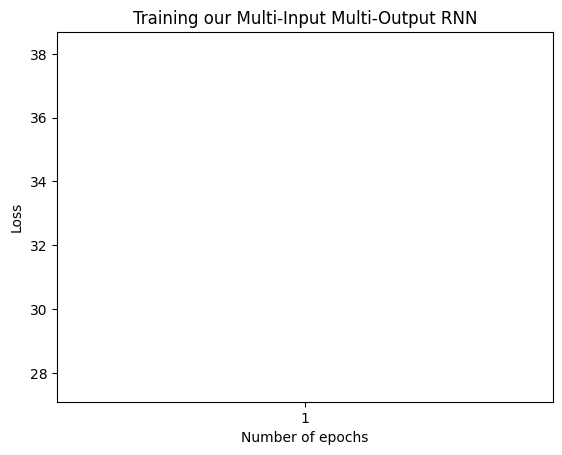

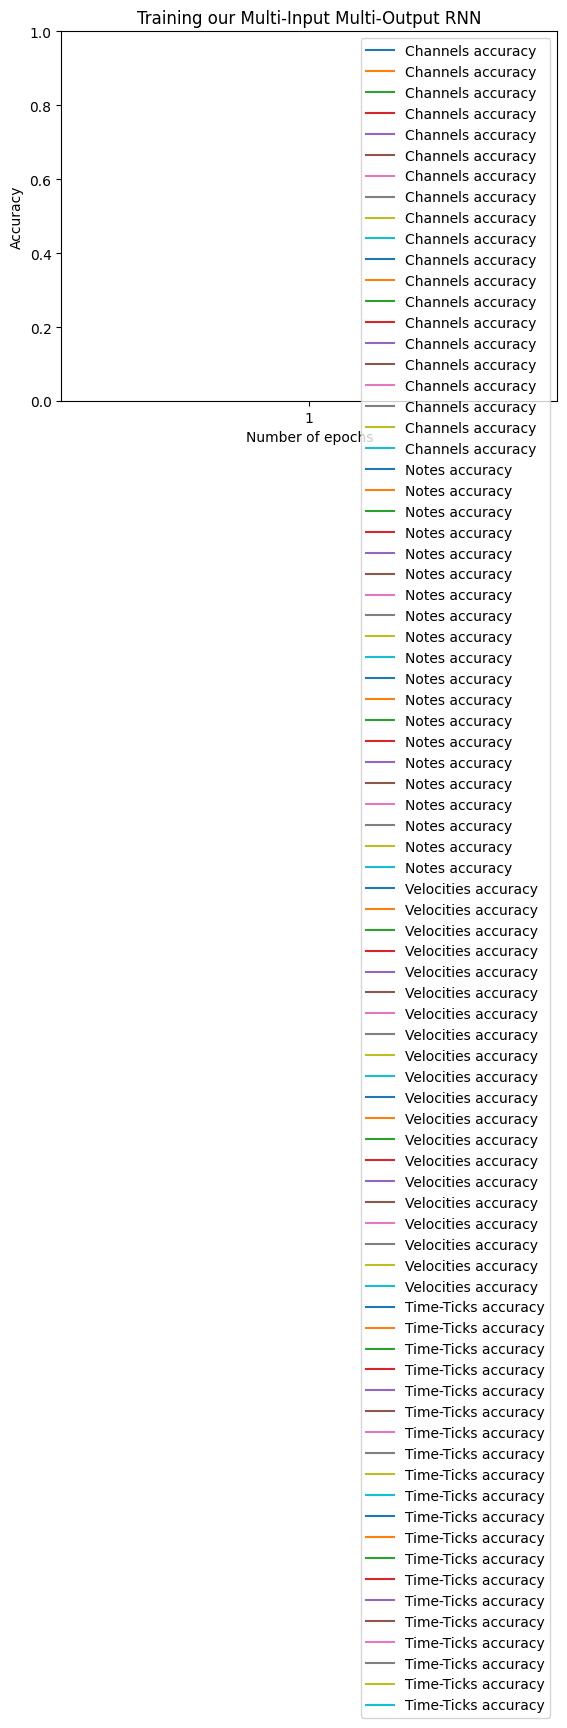

In [10]:
x = range(1,len(loss)+1)
plt.figure()
plt.plot(x, loss)
plt.title("Training our Multi-Input Multi-Output RNN")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.xticks(x)
plt.show()
plt.figure()
plt.plot(x, channels_accuracy, label="Channels accuracy")
plt.plot(x, notes_accuracy, label="Notes accuracy")
plt.plot(x, velocities_accuracy, label="Velocities accuracy")
plt.plot(x, ticks_accuracy, label="Time-Ticks accuracy")
plt.legend()
plt.ylim([0,1])
plt.title("Training our Multi-Input Multi-Output RNN")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.xticks(x)
plt.show()

In [11]:
def next_sequence(input_channel_data,input_notes_data,input_velocities_data,input_ticks_data, model):
  

    predictions = model.predict([input_channel_data, input_notes_data, input_velocities_data, input_ticks_data])

    channels_prediction, notes_prediction, velocities_prediction, ticks_prediction = predictions



    return channels_prediction, notes_prediction, velocities_prediction, ticks_prediction

In [35]:
def UpdateVect(original_vector,new_vector):
    new_vector_expanded = new_vector.reshape(1, 1, len(new_vector))


    extended_vector = np.append(original_vector, new_vector_expanded, axis=1)

    modified_vector = np.delete(extended_vector, 0, axis=1)
    return modified_vector

In [36]:

input_channels_data = X_channels[0:1,:,:]
input_notes_data = X_notes[0:1,:,:]
input_velocities_data = X_velocities[0:1,:,:]
input_ticks_data = X_ticks[0:1,:,:]

channel=[input_channels_data]
notes=[input_notes_data]
velocities=[input_velocities_data]
ticks=[input_ticks_data]

for k in range(4):
    print(k)
    channels_prediction, notes_prediction, velocities_prediction, ticks_prediction=next_sequence(channel[-1],notes[-1],velocities[-1],ticks[-1], model)
    # Select the most probable note using argmax
    next_note = ind_to_note[np.argmax(notes_prediction[0, -1, :])]
    next_channel = ind_to_channel[np.argmax(channels_prediction[0, -1, :])]
    next_velocity = velocities_prediction[0, -1, 0]
    next_tick = ticks_prediction[0, -1, 0]
    print(next_note)
        # Append the selected note to the generated sequence
    #generated_notes.append(next_note)

        # Prepare the input for the next prediction
    channel.append(next_channel)
    notes.append(next_note)
    velocities.append(next_velocity)
    ticks.append(next_tick)
    OneHotChannels = pp.one_hot_encode(channel_to_ind,next_channel)
    OneHotNotes = pp.one_hot_encode(note_to_ind,next_note)
    AllVelocities = next_velocity.reshape((-1,1))
    AllTicks = AllTicks.reshape((-1,1))
    X_channels=UpdateVect(X_channels,OneHotChannels)
    X_notes=UpdateVect(X_notes,OneHotNotes)
    X_velocities=UpdateVect(X_velocities,AllVelocities)
    X_ticks=UpdateVect(X_ticks,AllTicks)
    

0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
74


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 71600 and the array at index 1 has size 1

In [33]:
#X_channels[0:1,:,:].shape
OneHotChannels.shape

(12,)

In [15]:
ind_to_note(63)

TypeError: 'dict' object is not callable

In [ ]:
#decode the data


In [ ]:
from midiutil import MIDIFile

In [ ]:
def CreateMIDIFile(channel,note,volume,ticks):
    MyMIDI = MIDIFile(1)  # One track, defaults to format 1 
    track=0
    tempo=60
    time=0
    MyMIDI.addTempo(track, time, tempo)

    for i, pitch in enumerate(AllNotes):
        MyMIDI.addNote(0, channel[i], pitch, time + i, ticks[i], volume[i])

    with open("major-scale.mid", "wb") as output_file:
        MyMIDI.writeFile(output_file)